In [1]:
import tensorflow as tf
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import math

2022-03-01 10:44:15.932349: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
DIR = os.getcwd() + "/train-val-test/db14/window-size-10/lag2/all-features/"

In [3]:
X_train = np.load(DIR + "X_train.npy")
y_train = np.load(DIR + "y_train.npy")
X_val = np.load(DIR + "X_val.npy")
y_val = np.load(DIR + "y_val.npy")
X_test = np.load(DIR + "X_test.npy")
y_test = np.load(DIR + "y_test.npy")

In [4]:
X_train.shape

(17370, 1, 30, 30)

In [ ]:
with tf.device("/gpu:0"):
    X_test = tf.convert_to_tensor(X_test)
    y_test = tf.convert_to_tensor(y_test)

In [5]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=os.getcwd() + "/cnn-tf/saved_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [6]:
input_details

[{'name': 'serving_default_actual_input:0',
  'index': 0,
  'shape': array([ 1,  1, 30, 30], dtype=int32),
  'shape_signature': array([ 1,  1, 30, 30], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [37]:
def eval_cnn(data, labels):
    correct = 0
    total = 0
    preds = []
    pred_probs = np.zeros((labels.shape[0],2))
    tp_exp = []

    # Test model on random input data.
    for i in range(data.shape[0]):
        input_shape = input_details[0]['shape']
        input_data = np.array(data[i,:,:,:][None,:,:,:], dtype=np.float32) #np.array(np.random.random_sample(input_shape), dtype=np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

        # The function `get_tensor()` returns a copy of the tensor data.
        # Use `tensor()` in order to get a pointer to the tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])[0]
        #print(output_data)
        #print(tf.math.argmax(abs(output_data), 1))
        #print(tf.math.argmax(abs(output_data), 1))

        pred = np.where(output_data == np.max(output_data))[0][0]
        
        preds.append(pred)
        pred_probs[i,pred] = output_data[pred]/(abs(output_data[pred]) + abs(output_data[pred-1]))
        pred_probs[i,pred-1] = 1-pred_probs[i,pred]
        acc = labels[i]
        #print(pred)
        #print(acc)
        #if pred < 0.5 and acc > 0.5:
        #    tp_exp.append(output_data)
            
        #print()
        if abs(pred - acc) < 0.1:
            correct += 1
        total += 1

    print(correct/total)
    print(confusion_matrix(preds, labels))
    print()
    return pred_probs #tp_exp

In [38]:
train_preds = eval_cnn(X_train, y_train)
val_preds = eval_cnn(X_val, y_val)
test_preds = eval_cnn(X_test, y_test)

0.9442141623488773
[[14588   631]
 [  338  1813]]

0.9335175271973752
[[4814  239]
 [ 146  592]]

0.9345536176826109
[[4838  241]
 [ 138  574]]



In [39]:
len(train_preds)

17370

In [40]:
y_train.flatten().shape

(17370,)

/home/hwixley/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


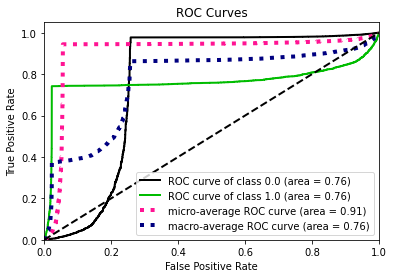

In [41]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_train
y_probas = train_preds
skplt.metrics.plot_roc_curve(list(y_true), y_probas)
plt.show()

In [44]:
a = np.arange(25)
a.reshape((5,5))

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [9]:
raw = tp_exp1 + tp_exp2 + tp_exp3
rows, cols = len(raw), 2
fps = np.zeros((rows, cols))

for i in range(rows):
    fps[i,:] = raw[i]

In [10]:
np.mean(fps, axis=0)

array([ 0.8966516, -0.7166468])

In [11]:
np.var(fps, axis=0)

array([0.40319429, 0.39502013])

In [12]:
diffs = fps[:,0] - fps[:,1]

In [13]:
diffs

array([0.05004492, 2.09515339, 0.81587905, ..., 1.65157866, 2.29083955,
       1.60314804])

In [14]:
print(np.mean(diffs))
print(np.var(diffs))

1.6132984001937212
1.5955293846300929
